In [135]:
import pandas as pd
import numpy as np
import os
import gc
from itertools import product
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline 

Notes:

Stacked by using date_block_num between 12-33 to train 1st level models LR and LGB to generate train data to train a final LR model.
Results in a score 0.98940 (place 133 as of 3.25.2018) with no hyperparameter optimization which is an improvement over previous commit.

Objective:

Predict total sales for every product and store in the next month based on lagged features with **stacking**.


Stacking for time series.
1. Split train data and test data sequentially (e.g, train is month 12-32 and test is month 33).
2. Create features (e.g lagging features of 1,3,6,12 months), and create new data set.
3. Select level 1 models (lr, gbm, etc)
4. Set duration T, for example T can be 1 month, and set M as range of data. In this case since starting from 12, set M to 15, so we create training meta features, by taking M and predicting M+1, then use all data to M+1 and predict M+2, so on. (In this case we should get (predictions, inputs) as (27,12-26), (28,12-27),(29,12-28),(30,12-29),(31,12-30),(32,12-31).
5. Use these predictions and the actual targets to find best MIX, (if only two level 1 models, then, find best \\(\alpha\\) such that \\(\alpha * model1 + (1-\alpha) * model2\\) results in best R2 score (target, mixed_prediction).
6. Once you have found best mix, test \\(\alpha\\) on test data, and calculate R2 (test_target, \\(\alpha\\) mixed \\(L1 \\)predictions)

### Load data

In [2]:
transactions = pd.read_csv('sales_train.csv.gz')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

print(transactions.shape)
print(items.shape)
print(item_categories.shape)
print(shops.shape)
transactions.head(3)

(2935849, 6)
(22170, 3)
(84, 2)
(60, 2)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [49]:
transactions.memory_usage(deep=True)

Index                    80
date              196701883
date_block_num     23486792
shop_id            23486792
item_id            23486792
item_price         23486792
item_cnt_day       23486792
dtype: int64

In [51]:
transactions.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

### Create Feature Matrix

1. Downcast types to save memory (method taken from Advanced ML HSE)

In [3]:
def downcast_dtypes(df):
    ''' Changes column types in the dataframe: 
        `float64` type to `float32`
        `int64`   type to `int32`
    Args:
        df - pandas data frame
    Returns:
        df - downcasted data frame
    '''
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    return df

def create_grid(sales, index_cols = ['shop_id', 'item_id', 'date_block_num']):
    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
        cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into pandas dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Get aggregated values for (shop_id, item_id, month)
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    
    # Join aggregated data to the grid
    all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
    
    # shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
    
    # Sort the data
    all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
    all_data = downcast_dtypes(all_data)
    return all_data

In [4]:
path = "transactions_all_data_2-1.csv"
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

if os.path.isfile(path):
    data = pd.read_csv(path)
else:
    data = create_grid(transactions, index_cols)
    data.to_csv(path, index=False)
    
gc.collect();

In [5]:
data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,0,19,0,0.0,5578.0,1.0
1,0,27,0,0.0,5578.0,7.0
2,0,28,0,0.0,5578.0,8.0
3,0,29,0,0.0,5578.0,4.0
4,0,32,0,6.0,5578.0,299.0


In [52]:
data.dtypes

shop_id                 int64
item_id                 int64
date_block_num        float64
target                float64
target_shop           float64
target_item           float64
target_lag_1          float64
target_item_lag_1     float64
target_shop_lag_1     float64
target_lag_3          float64
target_item_lag_3     float64
target_shop_lag_3     float64
target_lag_12         float64
target_item_lag_12    float64
target_shop_lag_12    float64
item_category_id        int64
dtype: object

In [54]:
data.nunique()

shop_id                  55
item_id               17432
date_block_num           23
target                  372
target_shop             858
target_item             668
target_lag_1            383
target_item_lag_1       691
target_shop_lag_1       885
target_lag_3            380
target_item_lag_3       714
target_shop_lag_3       889
target_lag_12           354
target_item_lag_12      693
target_shop_lag_12      856
item_category_id         80
dtype: int64

### Aggregates as a form of mean encoding
Note that assigning aggregate values as a feature is a form of mean encoding.

In [7]:
# Check if aggregates make sense
# Total sales for item_id 32 for date block 0 is 299
assert(data[(data.item_id == 32) & (data.date_block_num==0)].target.sum()==299)
# Total sales for shop_id 0 for date block 0 is 5578
assert(data[(data.shop_id == 0) & (data.date_block_num==0)].target.sum()==5578)


#### Change test set dimensions to match the rest of data

In [8]:
test = pd.read_csv('test.csv')
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [9]:
test_orig = test.copy()
test['date_block_num'] = np.ones(len(test.index))* 34
test['target'] = np.zeros(len(test.index))
test['target_shop'] = np.zeros(len(test.index))
test['target_item'] = np.zeros(len(test.index))
cols = test.columns.tolist()
print(cols)
test = test[cols]
ID = test['ID']
del test['ID']

test.head()

['ID', 'shop_id', 'item_id', 'date_block_num', 'target', 'target_shop', 'target_item']


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,5,5037,34.0,0.0,0.0,0.0
1,5,5320,34.0,0.0,0.0,0.0
2,5,5233,34.0,0.0,0.0,0.0
3,5,5232,34.0,0.0,0.0,0.0
4,5,5268,34.0,0.0,0.0,0.0


In [10]:
test.shape

(214200, 6)

In [11]:
all_data = pd.concat([data,test], axis=0)

In [12]:
assert(all_data.shape[0] == data.shape[0] + test.shape[0])

### Get Lagged features

Using 1,3,12 for ranges. (Note: Adding more lagged features resulted in memry issues. Need to address)

In [ ]:
data = all_data


# List of columns that we will use to create lags
cols_to_rename = list(data.columns.difference(index_cols)) 
print(cols_to_rename)

# Lags to use
shift_range = [1,3,12]

for month_shift in tqdm_notebook(shift_range):
    
    train_shift = data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    data = pd.merge(data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
data = data[data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

data = pd.merge(data, item_category_mapping, how='left', on='item_id')
data = downcast_dtypes(data)
gc.collect();

In [13]:
path = "2-1-lagged-features-all.csv"

if os.path.isfile(path):
    data = pd.read_csv(path)
else:
    data.to_csv(path, index=False)

In [14]:
data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,2,27,12.0,0.0,890.0,1.0,0.0,4.0,1322.0,0.0,6.0,795.0,1.0,7.0,1146.0,19
1,2,30,12.0,0.0,890.0,58.0,0.0,47.0,1322.0,0.0,24.0,795.0,0.0,0.0,0.0,40
2,2,31,12.0,0.0,890.0,15.0,0.0,25.0,1322.0,0.0,25.0,795.0,0.0,0.0,0.0,37
3,2,32,12.0,1.0,890.0,84.0,0.0,89.0,1322.0,0.0,58.0,795.0,0.0,299.0,1146.0,40
4,2,33,12.0,1.0,890.0,42.0,1.0,42.0,1322.0,0.0,33.0,795.0,1.0,61.0,1146.0,37


In [15]:
#TODO
# Split train and vali
# http://vita.had.co.nz/papers/tidy-data.pdf
# https://github.com/tdpetrou/Learn-Pandas/blob/master/Data%20Analysis%20Routine/Beginning%20Data%20Analysis%20Routine%20Checklist.md

### Train/Valid/Test Split

In [33]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = data['date_block_num']

last_block = dates.max()
print('Test`date_block_num` is %d' % last_block)

Test`date_block_num` is 34


In [34]:
to_drop_cols=['target_item', 'target', 'target_shop', 'date_block_num']

In [35]:
dates.unique()

array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34.])

Split the data into train and validation.

Note: need to drop 'target_item', 'target', 'target_shop', 'date_block_num' as leaving them will introduce look ahead bias.

In [133]:
dates_train_full = dates[dates <  last_block] # < 34
dates_train = dates[dates <  last_block - 1] # < 33
dates_test  = dates[dates == last_block] # 34
dates_valid = dates.unique()[-2:-1] # 33

# Drop columns that would introduce look ahead bias
X_train_full =  data.loc[dates < last_block].drop(to_drop_cols, axis=1)
X_train = data.loc[dates <  dates_valid[0]].drop(to_drop_cols, axis=1)
X_valid = data.loc[dates.isin(dates_valid)].drop(to_drop_cols, axis=1)
X_test =  data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train_full = data.loc[dates < last_block, 'target'].values
y_train = data.loc[dates < dates_valid[0], 'target'].values
y_valid = data.loc[dates.isin(dates_valid), 'target'].values
y_test =  data.loc[dates == last_block, 'target'].values



In [74]:
dates_train.shape

(6186922,)

In [75]:
print(X_train.shape)
print(y_train.shape)

(6186922, 12)
(6186922,)


In [76]:
X_test.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
6425094,5,5037,0.0,25.0,1052.0,3.0,119.0,1294.0,1.0,65.0,1445.0,19
6425095,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
6425096,5,5233,1.0,42.0,1052.0,1.0,150.0,1294.0,0.0,0.0,0.0,19
6425097,5,5232,0.0,28.0,1052.0,1.0,65.0,1294.0,0.0,0.0,0.0,23
6425098,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20


### Get meta-features using level 1 models

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_valid.values)

print('Test R-squared for linreg is %f' % r2_score(y_valid, pred_lr))

Test R-squared for linreg is 0.218948


In [78]:
import lightgbm as lgb

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_valid)

print('Test R-squared for LightGBM is %f' % r2_score(y_valid, pred_lgb))

Test R-squared for LightGBM is 0.304843


### Valid Meta Features

In [79]:
# Create meta-features
X_valid_level2 = np.c_[pred_lr, pred_lgb] 

In [80]:
dates_train.shape

(6186922,)

In [87]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [88]:
# Create 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    ''' 
    pred_idx = np.where(dates_train==cur_block_num)
    train_idx = np.where(dates_train < cur_block_num)
    lr = LinearRegression()
    
    y = y_train[train_idx]
    X = X_train.iloc[train_idx].values
    X_pred = X_train.iloc[pred_idx].values
    lr.fit(X, y)
    pred_lr = lr.predict(X_pred)
    
    
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    model = lgb.train(lgb_params, lgb.Dataset(X, label=y), 100)
    pred_lgb = model.predict(X_pred)
    preds = np.c_[pred_lr, pred_lgb]

    X_train_level2[np.where(dates_train_level2 == cur_block_num)] = preds 

# Sanity check
#assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32


Ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig scatter plot between the two metafeatures.

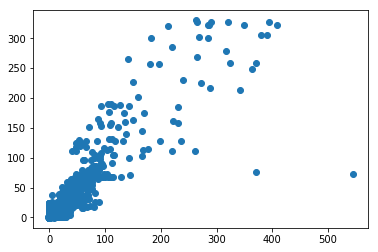

In [90]:
plt.scatter(X_train_level2[:,0],X_train_level2[:,1])

In [91]:
print(y_train_level2.shape)
print(X_train_level2.shape)

(1376192,)
(1376192, 2)


Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [92]:
alphas_to_try = np.linspace(0, 1, 1001)

best_a = -1
best_r2 = 0
for a in alphas_to_try:
    mix = a * X_train_level2[:,0] + (1-a)*X_train_level2[:,1]
    current_r2 = r2_score(y_train_level2, mix)
    if current_r2 > best_r2:
        best_r2 = current_r2
        best_a = a
        

# YOUR CODE GOES HERE
best_alpha = best_a
r2_train_simple_mix = best_r2 # YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.236000; Corresponding r2 score on train: 0.248185


### Ensembling using alphas generated from training predictions

In [98]:
valid_preds = best_alpha * X_valid_level2[:,0] + (1-best_alpha)*X_valid_level2[:,1]
r2_valid_simple_mix = r2_score(y_valid, valid_preds)

print('Valid R-squared for simple mix is %f' % r2_valid_simple_mix)

Valid R-squared for simple mix is 0.291879


### Stacking

#### Linear Regression

In [121]:
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)

train_preds = lr.predict(X_train_level2)
r2_train_stacking =r2_score(y_train_level2, train_preds)

valid_preds = lr.predict(X_valid_level2)
r2_valid_stacking = r2_score(y_valid, valid_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Valid  R-squared for stacking is %f' % r2_valid_stacking)

Train R-squared for stacking is 0.248591
Valid  R-squared for stacking is 0.298066


#### XGB
Use default for first pass.

In [101]:
import xgboost as xgb

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [103]:
xgb = xgb.XGBRegressor()

In [105]:
xgb.fit(X_train_level2, y_train_level2)

train_preds = xgb.predict(X_train_level2)
r2_train_stacking =r2_score(y_train_level2, train_preds)

valid_preds = xgb.predict(X_valid_level2)
r2_valid_stacking = r2_score(y_valid, valid_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Valid  R-squared for stacking is %f' % r2_valid_stacking)

Train R-squared for stacking is 0.474427
Valid  R-squared for stacking is 0.153491


### Create predictions for test

In [136]:
# linear regression
lr_stack = LinearRegression()
# Use train full to fit
lr_stack.fit(X_train_full.values, y_train_full)
pred_lr = lr_stack.predict(X_test.values)

# lgb
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

lgb_stack = lgb.train(lgb_params, lgb.Dataset(X_train_full, label=y_train_full), 100)
pred_lgb = lgb_stack.predict(X_test)

### Test meta features

In [137]:
# Create meta-features
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta for entire training set

In [139]:
dates_train_full_level2 = dates_train_full[dates_train_full.isin([27, 28, 29, 30, 31, 32,33])]

# That is how we get target for the 2nd level dataset
y_train_full_level2 = y_train_full[dates_train_full.isin([27, 28, 29, 30, 31, 32,33])]

# Create 2nd level feature matrix, init it with zeros first
X_train_full_level2 = np.zeros([y_train_full_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train_full` into parts
           Remember, that corresponding dates are stored in `dates_train_full` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_full_level2`. 
           You can use `dates_train_full_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    ''' 
    pred_idx = np.where(dates_train_full==cur_block_num)
    train_idx = np.where(dates_train_full < cur_block_num)
    lr = LinearRegression()
    
    y = y_train_full[train_idx]
    X = X_train_full.iloc[train_idx].values
    X_pred = X_train_full.iloc[pred_idx].values
    lr.fit(X, y)
    pred_lr = lr.predict(X_pred)
    
    
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    model = lgb.train(lgb_params, lgb.Dataset(X, label=y), 100)
    pred_lgb = model.predict(X_pred)
    preds = np.c_[pred_lr, pred_lgb]

    X_train_full_level2[np.where(dates_train_full_level2 == cur_block_num)] = preds 


27
28
29
30
31
32
33


In [140]:
final_stack_lr = LinearRegression()
final_stack_lr.fit(X_train_full_level2, y_train_full_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [141]:
# Get predictions for test data
test_preds = final_stack_lr.predict(X_test_level2)


In [142]:
print(len(test_preds))
print(len(test))

214200
214200


In [143]:
test_temp = test.copy()

In [144]:
test_temp.target = test_preds
del test_temp['target_shop']
del test_temp['target_item']
del test_temp['date_block_num']
test_temp.head()

,shop_id,item_id,target
0,5,5037,0.536237
1,5,5320,0.147753
2,5,5233,0.608242
3,5,5232,0.422644
4,5,5268,1.444430


In [145]:
submission = test_orig.copy()
submission_temp = submission.merge(test_temp, on=['shop_id','item_id'], how='left')
submission_temp.head()

,ID,shop_id,item_id,target
0,0,5,5037,0.536237
1,1,5,5320,0.147753
2,2,5,5233,0.608242
3,3,5,5232,0.422644
4,4,5,5268,1.444430


In [146]:
submission_temp.max()

ID         214199.000000
shop_id        59.000000
item_id     22167.000000
target        407.998036
dtype: float64

In [147]:
sample = pd.read_csv('sample_submission.csv')
final_submission = sample.copy()
final_submission.item_cnt_month = submission_temp.target.clip(0,20)
final_submission.head()

,ID,item_cnt_month
0,0,0.536237
1,1,0.147753
2,2,0.608242
3,3,0.422644
4,4,1.444430


In [148]:
final_submission.to_csv('2-3-v0-submission.csv',index=False)